Paquetes necesarios

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

#Identificación de monedas

Carga imagen y convierte a RGB

(938, 473, 3)


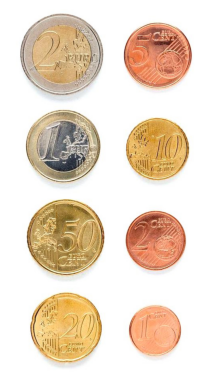

In [3]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

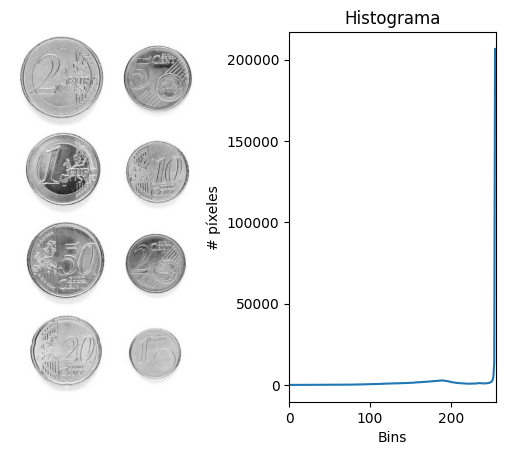

In [5]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])
# Separo subplots horizontalmente
plt.subplots_adjust(wspace=0.4)

Cuenta resultado tras umbralizar (poniendo a negro el fondo)

Umbral fijo usado  200.0
Umbral Otsu  204.0


Text(0.5, 1.0, 'OTSU invertida')

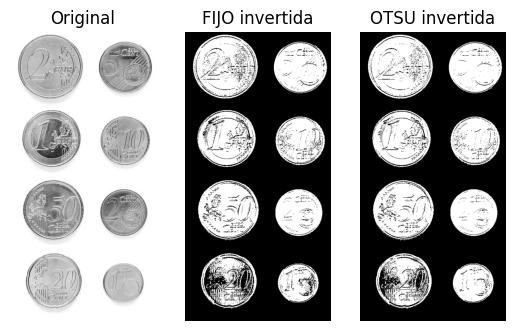

In [6]:
#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 200 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


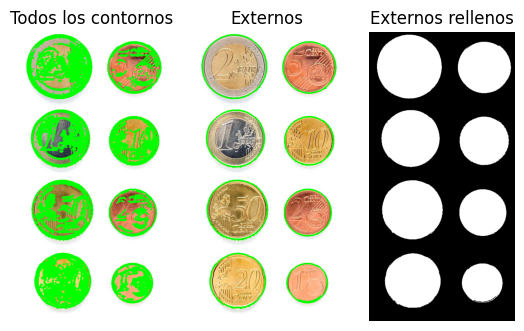

In [7]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con  figura en blanco y fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales (contornos contenidos en otros)

#Obtiene todos los contornos: externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

#Dibuja sobre la imagen de entrada los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos puede interesará mostrar los valores obtenidos del contorno
            #print(area, perimetro, rect, cx,cy,radio, elipse)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()


Alternativa contando círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


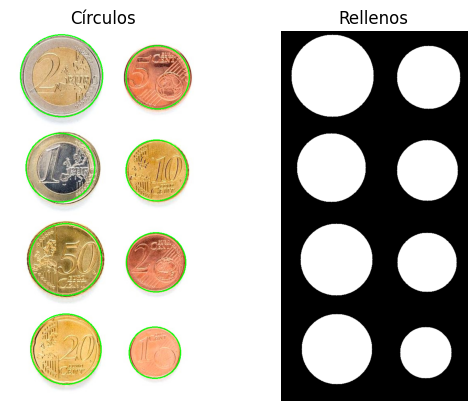

In [8]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

Las formas localizadas tienen distintas características geométricas, que pueden estimarse a partir de sus contornos. Más información en la [documentación de OpenCV](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html).

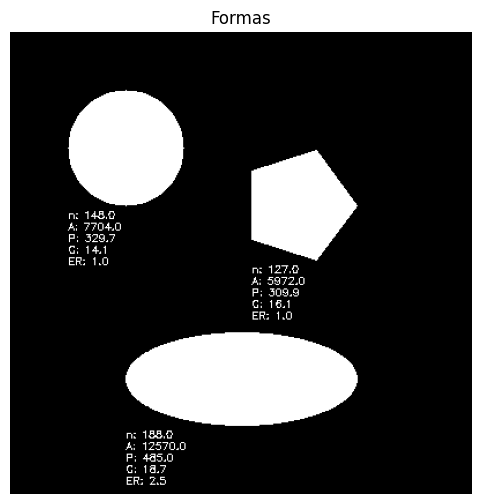

In [9]:
#Creación de polígono regular
def poligono_regular(image, ctr, radio, lados, color):
    pts = []
    ang_step = 2 * np.pi / lados
    for i in range(lados):
        ang = i * ang_step
        x = int(ctr[0] + radio * np.cos(ang))
        y = int(ctr[1] + radio * np.sin(ang))
        pts.append((x, y))
    pts = np.array(pts, np.int32)
    #regorganiza
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image, [pts], color=color)

# Imagen vacía
img = np.zeros((400, 400, 1), dtype="uint8")
color = (255, 255, 255)

# Formas básicas
cv2.circle(img, (100, 100), 50, color, -1)  # Circular
poligono_regular(img, (250, 150), 50, 5, color)  # Polígono regular
cv2.ellipse(img, (200, 300), (100, 40), 0, 0, 360, color, -1)  # Elíptica

# Localiza contornos
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Parámeros texto
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.3
thickness = 1

# Process each contour to calculate compactness and ellipse ratio (if possible)
for c in contours:
    # Puntos del contorno
    clon = len(c)

    # Área y perímetro
    area = cv2.contourArea(c)
    perimetro = cv2.arcLength(c, True)

    #Contenedor alineado con ejes de la imagen
    x,y,w,h = cv2.boundingRect(c)
    
    # Compactness: 4*pi*Area/Perimeter^2
    if perimetro > 0:
        compacidad = (perimetro ** 2) / area
    else:
        compactness = 0
    
    # Ajusta elipse si hay suficientes puntos
    if clon >= 5:
        elipse = cv2.fitEllipse(c)
        (center, axes, orientation) = elipse
        major_axis = max(axes)
        minor_axis = min(axes)
        elipse_ratio = major_axis / minor_axis
    else:
        elipse_ratio = None
    
    # Muestra valores en imageb
    cv2.putText(img, f"n: {clon:.1f}", (x, int(y+h+10)), font, font_scale, (255, 255, 255), thickness)
    cv2.putText(img, f"A: {area:.1f}", (x, int(y+h+20)), font, font_scale, (255, 255, 255), thickness)
    cv2.putText(img, f"P: {perimetro:.1f}", (x, int(y+h+30)), font, font_scale, color, thickness)
    cv2.putText(img, f"C: {compacidad:.1f}", (x, int(y+h+40)), font, font_scale, color, thickness)
    cv2.putText(img, f"ER: {elipse_ratio:.1f}", (x, int(y+h+50)), font, font_scale, color, thickness)
    
# Visualiza la imagen
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Formas")
plt.axis('off')
plt.show()


TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



In [2]:
# TAREA: Identificación y conteo de monedas con diferenciación por color
# Basado directamente en el código de detección de contornos externos de las celdas anteriores
# Con entrada por ventana OpenCV como en VC_P1

import math
from matplotlib.patches import Circle

# Diámetros de las monedas en mm (monedas euro)
DIAMETROS_MONEDAS = {
    '1€': 23.25,
    '2€': 25.75,
    '50c': 24.25,
    '20c': 22.25,
    '10c': 19.75,
    '5c': 21.25,
    '2c': 18.75,
    '1c': 16.25
}

# Valores de las monedas en céntimos
VALORES_MONEDAS = {
    '1€': 100,
    '2€': 200,
    '50c': 50,
    '20c': 20,
    '10c': 10,
    '5c': 5,
    '2c': 2,
    '1c': 1
}

def obtener_contornos_monedas_mejorado(img):
    """
    Versión mejorada que detecta mejor las monedas pequeñas
    """
    # Convertir a escala de grises
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    contornos_validos = []
    centros_usados = []
    
    # Múltiples umbrales para capturar todas las monedas
    umbrales = [180, 200, 220]  # Diferentes valores de umbral
    
    for umbral in umbrales:
        # Umbralización
        th1, img_th1 = cv2.threshold(img_gris, umbral, 255, cv2.THRESH_BINARY_INV)
        
        # Operaciones morfológicas para limpiar
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        img_th1 = cv2.morphologyEx(img_th1, cv2.MORPH_CLOSE, kernel)
        img_th1 = cv2.morphologyEx(img_th1, cv2.MORPH_OPEN, kernel)
        
        # Obtener contornos externos
        contornos2, hierarchy2 = cv2.findContours(img_th1, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE)
        
        # Filtrar contornos válidos
        for c in contornos2:
            area = cv2.contourArea(c)
            if area > 800:  # Área mínima reducida para monedas pequeñas
                perimetro = cv2.arcLength(c, True)
                x, y, w, h = cv2.boundingRect(c)
                (cx, cy), radio = cv2.minEnclosingCircle(c)
                
                # Verificar circularidad
                if perimetro > 0:
                    circularidad = 4 * np.pi * area / (perimetro * perimetro)
                    if circularidad > 0.4:  # Más permisivo
                        # Verificar si ya tenemos una moneda cerca
                        es_nueva = True
                        for centro_usado in centros_usados:
                            distancia = np.sqrt((cx - centro_usado[0])**2 + (cy - centro_usado[1])**2)
                            if distancia < 30:
                                es_nueva = False
                                break
                        
                        if es_nueva:
                            contornos_validos.append({
                                'contorno': c,
                                'area': area,
                                'perimetro': perimetro,
                                'centro': (int(cx), int(cy)),
                                'radio': radio,
                                'bbox': (x, y, w, h),
                                'circularidad': circularidad
                            })
                            centros_usados.append((cx, cy))
    
    return contornos_validos, img_gris

def extraer_caracteristicas_color(img, centro, radio):
    """
    Extrae características de color de una moneda
    """
    # Crear máscara circular
    mascara = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.circle(mascara, centro, int(radio * 0.8), 255, -1)
    
    # Convertir a HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    pixeles = hsv[mascara > 0]
    
    if len(pixeles) > 0:
        h_promedio = np.mean(pixeles[:, 0])
        s_promedio = np.mean(pixeles[:, 1]) 
        v_promedio = np.mean(pixeles[:, 2])
        return h_promedio, s_promedio, v_promedio
    else:
        return 0, 0, 0

def clasificar_moneda(diametro_mm, h, s, v):
    """
    Clasifica una moneda basándose en tamaño y color
    """
    mejor_match = None
    mejor_score = 0
    
    for tipo, diametro_esperado in DIAMETROS_MONEDAS.items():
        # Score por tamaño
        error_tamaño = abs(diametro_mm - diametro_esperado) / diametro_esperado
        if error_tamaño < 0.25:  # Tolerancia del 25%
            score_tamaño = 1 - error_tamaño
            
            # Score por color (clasificación simple por familias)
            score_color = 0.5  # Score base
            
            # Monedas plateadas/bimetálicas (1€, 2€)
            if tipo in ['1€', '2€']:
                if s < 60 and v > 50:  # Baja saturación, buen brillo
                    score_color = 0.8
            
            # Monedas doradas (50c, 20c, 10c)
            elif tipo in ['50c', '20c', '10c']:
                if 10 <= h <= 40 and s > 30:  # Tonos amarillos/dorados
                    score_color = 0.8
            
            # Monedas cobrizas (5c, 2c, 1c)  
            elif tipo in ['5c', '2c', '1c']:
                if 5 <= h <= 25 and s > 20:  # Tonos rojizos/marrones
                    score_color = 0.8
            
            # Score total
            score_total = score_tamaño * 0.7 + score_color * 0.3
            
            if score_total > mejor_score:
                mejor_score = score_total
                mejor_match = tipo
    
    return mejor_match, mejor_score

def crear_imagen_seleccion(img_rgb, contornos_monedas):
    """
    Crea imagen con monedas numeradas para selección
    """
    img_seleccion = img_rgb.copy()
    
    # Dibujar círculos y números
    for i, moneda in enumerate(contornos_monedas):
        cx, cy = moneda['centro']
        radio = int(moneda['radio'])
        
        # Círculo rojo alrededor de la moneda
        cv2.circle(img_seleccion, (cx, cy), radio, (0, 0, 255), 3)
        
        # Número en el centro
        cv2.putText(img_seleccion, str(i+1), (cx-15, cy+5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 0), 3)
        
        # Fondo negro para el número
        cv2.circle(img_seleccion, (cx, cy), 20, (0, 0, 0), -1)
        cv2.putText(img_seleccion, str(i+1), (cx-15, cy+5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 0), 3)
    
    # Agregar instrucciones
    cv2.putText(img_seleccion, "Presiona el numero de la moneda de 1 euro", 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    cv2.putText(img_seleccion, "o ESC para salir", 
               (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    return img_seleccion

def sistema_monedas_opencv():
    """
    Sistema con entrada por ventana OpenCV (como en VC_P1)
    """
    # Cargar imagen
    img = cv2.imread('Monedas.jpg') 
    print("Forma de la imagen:", img.shape)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    print("=== SISTEMA DE IDENTIFICACIÓN DE MONEDAS ===")
    print("Usando entrada por ventana OpenCV")
    print()
    
    # Obtener contornos mejorado
    contornos_monedas, img_gris = obtener_contornos_monedas_mejorado(img)
    
    print(f"Contornos válidos detectados: {len(contornos_monedas)}")
    
    if len(contornos_monedas) == 0:
        print("No se detectaron monedas válidas")
        return
    
    # Mostrar información de monedas detectadas
    print("\\nMonedas detectadas:")
    for i, moneda in enumerate(contornos_monedas):
        print(f"  {i+1}: Área = {moneda['area']:.0f} px², Radio = {moneda['radio']:.1f} px")
    
    # Crear imagen para selección
    img_seleccion = crear_imagen_seleccion(img, contornos_monedas)
    
    # Mostrar ventana y esperar entrada (como en VC_P1)
    cv2.imshow('Selecciona moneda de 1 euro', img_seleccion)
    
    seleccion = -1
    while True:
        key = cv2.waitKey(0) & 0xFF
        
        if key == 27:  # ESC para salir
            print("\\nOperación cancelada")
            cv2.destroyAllWindows()
            return
        
        # Verificar si es un número válido
        if key >= ord('1') and key <= ord('9'):
            numero = key - ord('0')
            if 1 <= numero <= len(contornos_monedas):
                seleccion = numero - 1
                break
            else:
                print(f"Número {numero} fuera de rango. Hay {len(contornos_monedas)} monedas.")
        
        print("Presiona un número válido (1-{}) o ESC para salir".format(len(contornos_monedas)))
    
    cv2.destroyAllWindows()
    
    print(f"\\nSeleccionada moneda {seleccion + 1} como referencia (1€)")
    
    # Calcular escala basada en moneda de referencia
    moneda_referencia = contornos_monedas[seleccion]
    radio_referencia_px = moneda_referencia['radio']
    radio_referencia_mm = DIAMETROS_MONEDAS['1€'] / 2
    escala = radio_referencia_mm / radio_referencia_px
    
    print(f"Escala calculada: {escala:.4f} mm/pixel")
    print(f"Basada en moneda de 1€ con radio de {radio_referencia_px:.1f} px")
    
    # Clasificar todas las monedas
    print("\\n" + "="*50)
    print("ANÁLISIS Y CLASIFICACIÓN")
    print("="*50)
    
    monedas_identificadas = {}
    valor_total = 0
    
    # Crear imagen final con resultados
    img_resultado = img.copy()
    
    for i, moneda in enumerate(contornos_monedas):
        cx, cy = moneda['centro']
        radio = int(moneda['radio'])
        
        # Calcular diámetro en mm
        diametro_mm = (radio * 2) * escala
        
        # Extraer color
        h, s, v = extraer_caracteristicas_color(img, (cx, cy), radio)
        
        # Clasificar
        tipo, confianza = clasificar_moneda(diametro_mm, h, s, v)
        
        print(f"\\nMoneda {i+1}:")
        print(f"  - Diámetro: {diametro_mm:.1f} mm")
        print(f"  - Color HSV: H={h:.0f}, S={s:.0f}, V={v:.0f}")
        
        if tipo and confianza > 0.4:
            print(f"  - Identificada como: {tipo} (confianza: {confianza:.2f})")
            
            # Contar y sumar valor
            if tipo not in monedas_identificadas:
                monedas_identificadas[tipo] = 0
            monedas_identificadas[tipo] += 1
            valor_total += VALORES_MONEDAS[tipo]
            
            # Color para visualización
            if tipo in ['1€', '2€']:
                color = (0, 255, 255)  # Amarillo en BGR
            elif tipo in ['50c', '20c', '10c']:
                color = (0, 165, 255)  # Naranja en BGR
            else:
                color = (0, 0, 255)    # Rojo en BGR
            
            # Dibujar en imagen
            cv2.circle(img_resultado, (cx, cy), radio, color, 3)
            cv2.putText(img_resultado, tipo, (cx-25, cy-radio-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        else:
            print(f"  - No identificada (confianza: {confianza:.2f})")
            
            # Mostrar como no identificada
            cv2.circle(img_resultado, (cx, cy), radio, (128, 128, 128), 2)
            cv2.putText(img_resultado, "?", (cx-10, cy+5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (128, 128, 128), 2)
    
    # Mostrar resultado final
    cv2.imshow('Resultado Final - Presiona cualquier tecla', img_resultado)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Resumen final
    print("\\n" + "="*50)
    print("RESUMEN FINAL")
    print("="*50)
    
    if monedas_identificadas:
        print("\\nMonedas identificadas:")
        for tipo in sorted(monedas_identificadas.keys(), key=lambda x: VALORES_MONEDAS[x], reverse=True):
            cantidad = monedas_identificadas[tipo]
            valor_tipo = VALORES_MONEDAS[tipo] * cantidad
            print(f"  {cantidad}x {tipo} = {valor_tipo} céntimos")
        
        euros = valor_total // 100
        centimos = valor_total % 100
        print(f"\\nVALOR TOTAL: {euros}€ {centimos:02d}c")
        print(f"Monedas identificadas: {sum(monedas_identificadas.values())}/{len(contornos_monedas)}")
    else:
        print("\\nNo se pudieron identificar monedas")
    
    print(f"\\nDetección: {len(contornos_monedas)} objetos circulares detectados")
    print("Sistema completado exitosamente")

# Ejecutar el sistema
sistema_monedas_opencv()

Forma de la imagen: (938, 473, 3)
=== SISTEMA DE IDENTIFICACIÓN DE MONEDAS ===
Usando entrada por ventana OpenCV

Contornos válidos detectados: 8
\nMonedas detectadas:
  1: Área = 17729 px², Radio = 76.0 px
  2: Área = 28088 px², Radio = 98.0 px
  3: Área = 25314 px², Radio = 94.0 px
  4: Área = 33466 px², Radio = 104.7 px
  5: Área = 12811 px², Radio = 65.7 px
  6: Área = 24775 px², Radio = 90.5 px
  7: Área = 19348 px², Radio = 79.9 px
  8: Área = 22107 px², Radio = 85.8 px
\nSeleccionada moneda 3 como referencia (1€)
Escala calculada: 0.1236 mm/pixel
Basada en moneda de 1€ con radio de 94.0 px
\n==================================================
ANÁLISIS Y CLASIFICACIÓN
\nMoneda 1:
  - Diámetro: 18.8 mm
  - Color HSV: H=8, S=145, V=211
  - Identificada como: 2c (confianza: 0.94)
\nMoneda 2:
  - Diámetro: 24.2 mm
  - Color HSV: H=20, S=139, V=185
  - Identificada como: 50c (confianza: 0.94)
\nMoneda 3:
  - Diámetro: 23.2 mm
  - Color HSV: H=47, S=38, V=150
  - Identificada como: 1€ (

#Clasificación de microplásticos

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV sobre una imagen de muestras de microplásticos.

Umbral escogido  197.0


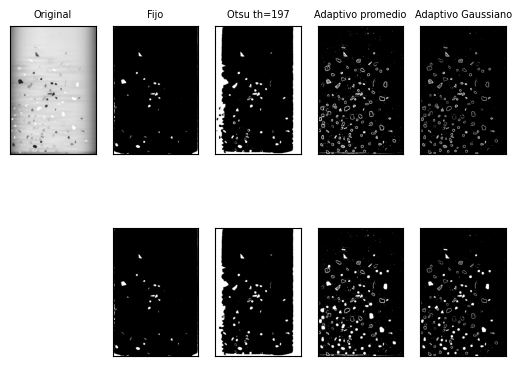

In [4]:
#Carga imagen directamente en grises
imgorig = cv2.imread('MPs_test.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Para esta imagen de muestras de microplásticos tenemos una anotación (que puede contener errores) de la tipología de las partículas. Esta será la imagen de test en los experimentos posteriores, no puedes hacer uso de esta imagen para entrenar tu clasificador, solo par evaluarlo

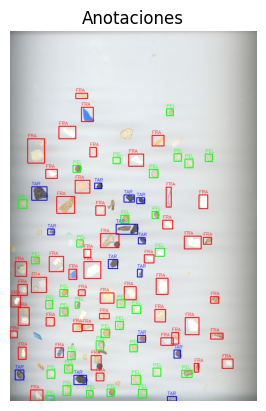

In [5]:
# Imagen y anotaciones
imagen = "MPs_test.jpg"          # Imagen original
csv_file = "MPs_test_bbs.csv"  # CSV con coordenadas y tipología

# Colores de cada clase
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

# Imagen
img = cv2.imread(imagen)

# Cara csv y dibujar rectángulos
with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        etiqueta = row["label"]
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        
        # Color según etiqueta
        color = colores.get(etiqueta, (0, 0, 0))  # negro por defecto si no encuentra
        
        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Etiqueta 
        cv2.putText(img, etiqueta, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Visualiza resultado
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Anotaciones")
plt.axis('off')
plt.show()


##Muestras de entrenamiento

Text(0.5, 1.0, 'Alquitrán')

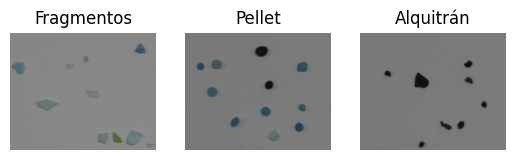

In [12]:
#Cargamos tres subimágenes, por simplicidad, de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas basadas en características geométricas y/o de apariencia, a partir de las imágenes completas de las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello sobre las anotaciones de la imagen de test *MPs_test.png*. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

Anotaciones  [1, 3, 3, 0, 3, 3, 1, 0, 0, 1, 2, 2, 3, 2, 1, 3, 0, 0, 2, 3, 3, 3, 1, 0, 1, 0, 0, 2, 3, 3, 1, 0, 2, 1, 0, 3, 0, 3, 1, 2, 0, 2, 2, 2, 1, 3, 0, 3, 1, 3, 1, 0, 2, 2, 1, 1, 1, 3, 0, 3, 0, 0, 0, 2, 3, 1, 0, 3, 3, 2, 3, 1, 3, 1, 0, 3, 2, 1, 0, 1, 3, 3, 3, 2, 3, 1, 2, 2, 2, 2, 1, 0, 2, 3, 1, 3, 2, 1, 1, 0]
Predicciones  [0, 1, 0, 1, 3, 0, 0, 2, 1, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 0, 3, 2, 1, 3, 3, 0, 3, 2, 3, 1, 1, 3, 1, 2, 1, 3, 1, 0, 2, 2, 3, 2, 3, 3, 2, 0, 0, 0, 1, 2, 2, 1, 1, 1, 3, 0, 1, 2, 0, 3, 2, 2, 3, 3, 1, 0, 2, 1, 2, 3, 0, 2, 1, 2, 3, 1, 1, 0, 1, 2, 3, 2, 1, 0, 1, 1, 3, 3, 1, 1, 0, 0, 2, 0, 1, 3, 0, 0, 1, 1]
¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.27
Precision (TP/(TP+FP)) = 0.2700018315018315
Recall (TP/(TP+FN)) = 0.27
F1 Score (2*(precision*recall)/(precision+recall)) = 0.26846197827329904


Text(38.25, 0.5, 'Real/Anotado')

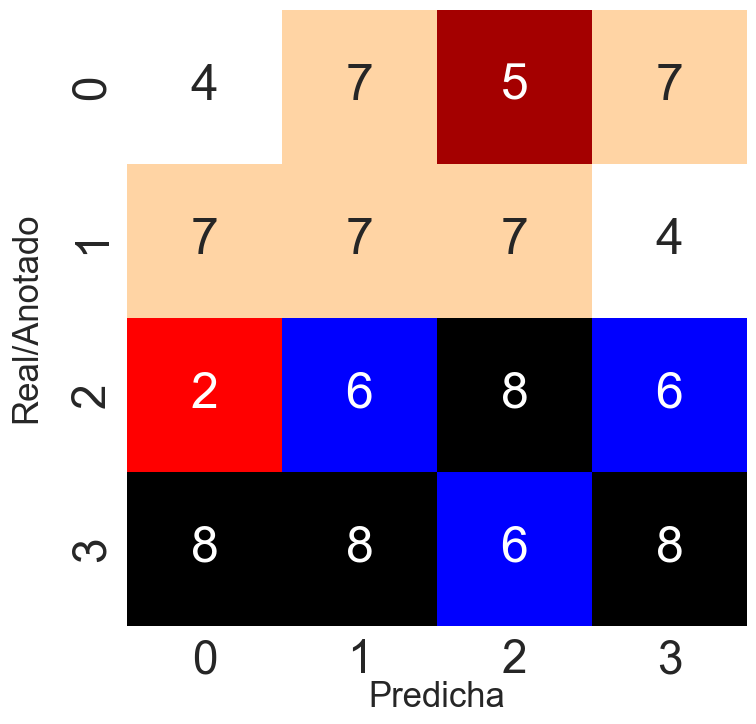

In [16]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

[INFO] Imagen fragment-03-olympus-10-01-2020.JPG - detecciones visualizadas (71 contornos)


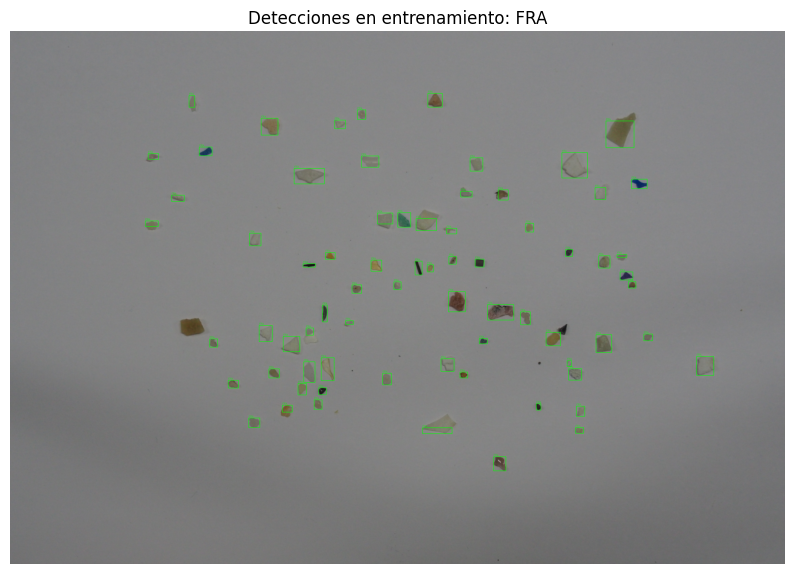

[INFO] Imagen pellet-03-olympus-10-01-2020.JPG - detecciones visualizadas (55 contornos)


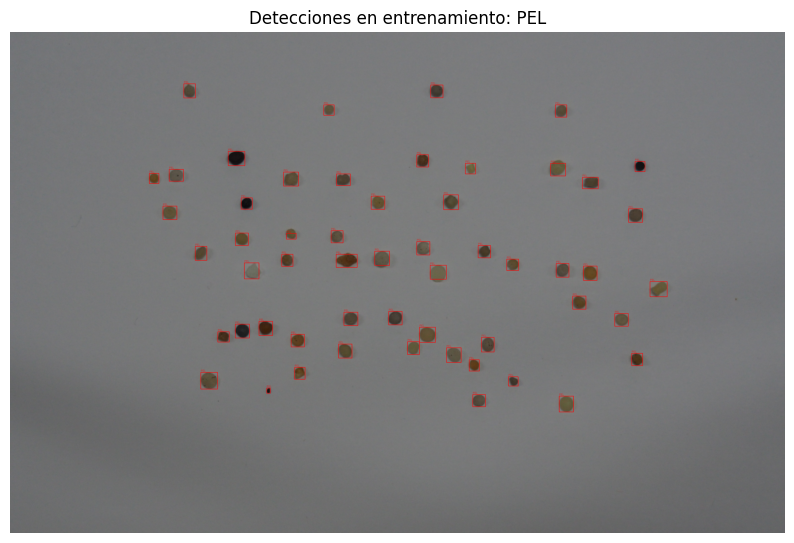

[INFO] Imagen tar-03-olympus-10-01-2020.JPG - detecciones visualizadas (54 contornos)


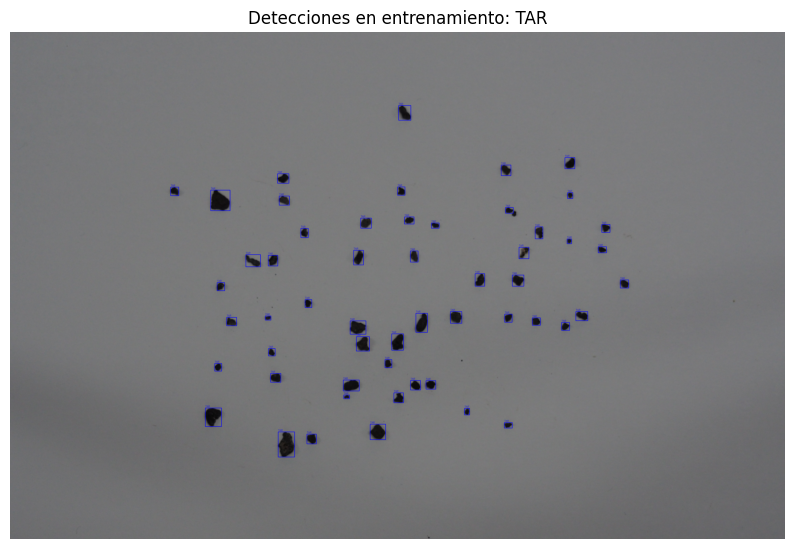

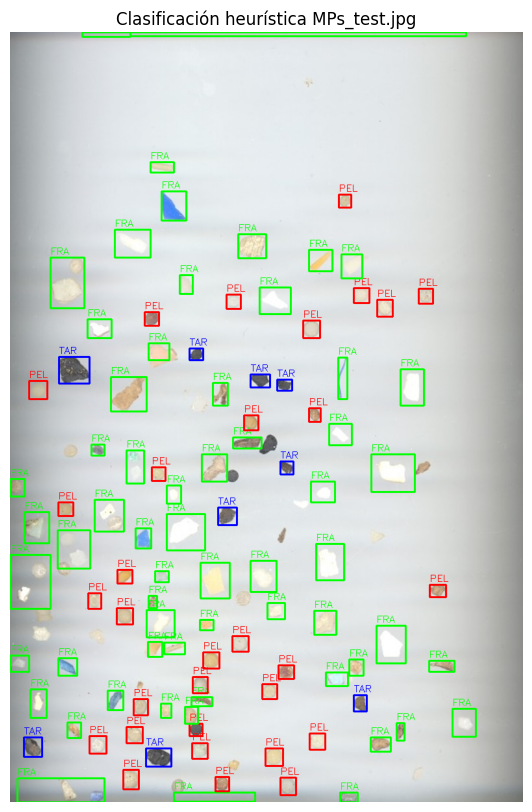

Accuracy=0.8933, Precision=0.9204, Recall=0.8631, F1=0.8852


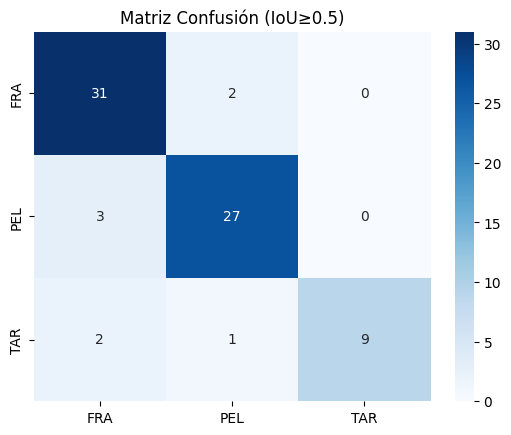

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# ===========================================================
# CONFIGURACIÓN
# ===========================================================
class Args:
    def __init__(self):
        self.train_images = [
            'fragment-03-olympus-10-01-2020.JPG',
            'pellet-03-olympus-10-01-2020.JPG',
            'tar-03-olympus-10-01-2020.JPG'
        ]
        self.test_image = 'MPs_test.jpg'
        self.test_csv = 'MPs_test_bbs.csv'
        self.output_dir = 'output_model'
        self.min_area_px = 80
        self.rf_trees = 500
        self.debug = True
        self.save_features = True
        self.save_masks = False

# Pesos heurísticos para clasificación ponderada
feature_weights = {
    "area": 3.5,
    "perimetro": 2.4,
    "compact": 4.5,
    "rel_area_cont": 2.25,
    "rel_aspecto": 3.5,
    "rel_ejes": 4.0,
    "rel_dist_centroid": 5.3,
    "black_dist": 3.5,
}

colores_bgr = {'FRA': (0,255,0), 'PEL': (0,0,255), 'TAR': (255,0,0), 'UNK': (128,128,128)}
clases = sorted(list(colores_bgr.keys())[:-1])  # ['FRA','PEL','TAR']

# ===========================================================
# FUNCIONES AUXILIARES
# ===========================================================

def iou_boxes(boxA, boxB):
    xA, yA, wA, hA = boxA
    xB, yB, wB, hB = boxB
    xA2, yA2, xB2, yB2 = xA+wA, yA+hA, xB+wB, yB+hB
    inter_w = max(0, min(xA2, xB2) - max(xA, xB))
    inter_h = max(0, min(yA2, yB2) - max(yA, yB))
    inter = inter_w * inter_h
    union = wA*hA + wB*hB - inter
    return inter / union if union else 0

def build_binary_mask(img_bgr, morph_kernel_size=5, debug=False):
    """Construye máscara binaria robusta usando CLAHE y umbral adaptativo"""
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge([l_eq, a, b])
    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    blur = cv2.bilateralFilter(cv2.cvtColor(img_eq, cv2.COLOR_BGR2GRAY), 9, 75, 75)
    mask_adapt = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 35, 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
    mask_clean = cv2.morphologyEx(mask_adapt, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)
    flood = mask_clean.copy()
    h,w = flood.shape[:2]
    mask_ff = np.zeros((h+2,w+2), np.uint8)
    cv2.floodFill(flood, mask_ff, (0,0), 255)
    mask_final = mask_clean | cv2.bitwise_not(flood)
    return img_eq, mask_final

def detectar_contornos_validos(img, min_area=300, max_area=10000, solapamiento_minimo=True):
    """Detecta contornos válidos tras corrección y filtrado"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    background = cv2.medianBlur(gray, 31)
    gray_corrected = cv2.addWeighted(gray, 1.5, background, -0.5, 0)
    mask = cv2.adaptiveThreshold(cv2.GaussianBlur(gray_corrected,(5,5),0), 255,
                                 cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]
    to_remove = set()
    for i in range(len(contours)):
        for j in range(i+1,len(contours)):
            val = iou_boxes(cv2.boundingRect(contours[i]), cv2.boundingRect(contours[j]))
            if val>0:
                if cv2.contourArea(contours[i]) < cv2.contourArea(contours[j]): to_remove.add(i)
                else: to_remove.add(j)
    return [c for k,c in enumerate(contours) if k not in to_remove]

def extraer_features_contornos(img, contours):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, rects = [], []
    for c in contours:
        area = cv2.contourArea(c)
        if area==0: continue
        perimetro = cv2.arcLength(c, True)
        x,y,w,h = cv2.boundingRect(c)
        rel_aspecto = w/h if h else 0
        rel_area_cont = area/(w*h) if w*h else 0
        compact = (perimetro**2)/(4*np.pi*area)
        rel_ejes = 0
        if len(c)>=5:
            try: (xc,yc),(MA,ma),ang=cv2.fitEllipse(c); rel_ejes=ma/MA if MA else 0
            except: rel_ejes=0
        M = cv2.moments(c)
        cx,cy=(int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])) if M["m00"] else (0,0)
        dists=[np.linalg.norm(np.array([cx,cy])-pt[0]) for pt in c]
        rel_dist_centroid=min(dists)/max(dists) if dists and max(dists)!=0 else 0
        mask_obj = np.zeros(gray.shape,np.uint8)
        cv2.drawContours(mask_obj,[c],-1,255,-1)
        mean_color = cv2.mean(img, mask=mask_obj)[:3]
        black_dist = np.linalg.norm(np.array(mean_color)-np.array([0,0,0]))
        features.append([area, perimetro, compact, rel_area_cont,
                         rel_aspecto, rel_ejes, rel_dist_centroid, black_dist])
        rects.append((x,y,w,h))
    return np.array(features), rects

def clasificar_normalizado_ponderado(x, features_train_norm, mu, sigma, weights):
    x_norm=(x-mu)/sigma
    w_values=np.array(list(weights.values()))
    dist={}
    for clase,muestras in features_train_norm.items():
        dists=[np.sqrt(np.sum((x_norm-v)**2*w_values**2)) for v in muestras]
        dist[clase]=np.mean(dists)
    return min(dist,key=dist.get)

# ===========================================================
# ENTRENAMIENTO
# ===========================================================
def entrenar_pipeline(train_images_dict):
    features_train={}
    for clase,f in train_images_dict.items():
        feats,_=procesar_imagen(f)
        if feats is not None: features_train[clase]=feats
    X_train=np.vstack([features_train[c] for c in clases if c in features_train])
    mu,sigma=np.mean(X_train,axis=0),np.std(X_train,axis=0)+1e-6
    features_train_norm={c:(features_train[c]-mu)/sigma for c in features_train}
    return features_train_norm, mu, sigma

def procesar_imagen(img_file, min_area=300, max_area=10000):
    img=cv2.imread(img_file)
    if img is None: return None,None
    contornos=detectar_contornos_validos(img,min_area,max_area)
    feats,rects=extraer_features_contornos(img,contornos)
    return feats,rects

# ===========================================================
# TEST Y EVALUACIÓN
# ===========================================================
def test_y_evaluar(test_img_file,test_csv,features_train_norm,mu,sigma):
    img_color=cv2.imread(test_img_file)
    contornos_test=detectar_contornos_validos(img_color,150,12000)
    features_test,rects_test=extraer_features_contornos(img_color,contornos_test)
    img_classified=img_color.copy()
    y_pred=[]
    for f,rect in zip(features_test,rects_test):
        pred=clasificar_normalizado_ponderado(f,features_train_norm,mu,sigma,feature_weights)
        y_pred.append(pred)
        x,y,w,h=rect
        color=colores_bgr.get(pred,(128,128,128))
        cv2.rectangle(img_classified,(x,y),(x+w,y+h),color,2)
        cv2.putText(img_classified,pred,(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img_classified,cv2.COLOR_BGR2RGB))
    plt.title(f"Clasificación heurística {test_img_file}"); plt.axis('off'); plt.show()

    # Cargar GT
    annotations=[]
    with open(test_csv,newline='') as file:
        reader=csv.DictReader(file)
        for row in reader:
            x_min,y_min,x_max,y_max=map(int,[row["x_min"],row["y_min"],row["x_max"],row["y_max"]])
            annotations.append({"label":row["label"],"rect":(x_min,y_min,x_max-x_min,y_max-y_min)})

    IOU_THRESHOLD=0.5
    y_true,y_pred_match,used_gt=[],[],set()
    for pred_rect,pred_label in zip(rects_test,y_pred):
        best_iou,best_idx=0,-1
        for j,gt in enumerate(annotations):
            if j not in used_gt:
                iou_val=iou_boxes(pred_rect,gt["rect"])
                if iou_val>best_iou: best_iou,best_idx=iou_val,j
        if best_iou>=IOU_THRESHOLD:
            gt_label=annotations[best_idx]["label"]
            if gt_label in clases:
                y_true.append(gt_label)
                y_pred_match.append(pred_label)
                used_gt.add(best_idx)

    if y_true:
        acc=accuracy_score(y_true,y_pred_match)
        prec=precision_score(y_true,y_pred_match,labels=clases,average='macro',zero_division=0)
        rec=recall_score(y_true,y_pred_match,labels=clases,average='macro',zero_division=0)
        f1=f1_score(y_true,y_pred_match,labels=clases,average='macro',zero_division=0)
        print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
        cm=confusion_matrix(y_true,y_pred_match,labels=clases)
        sns.heatmap(pd.DataFrame(cm,index=clases,columns=clases),annot=True,fmt="d",cmap="Blues")
        plt.title("Matriz Confusión (IoU≥0.5)"); plt.show()
    else:
        print("No se pudieron calcular métricas (sin coincidencias IoU≥0.5)")

# ===========================================================
# EJECUCIÓN PRINCIPAL CON VISUALIZACIÓN DE DETECCIONES EN TRAIN
# ===========================================================
if __name__=="__main__":
    args = Args()
    os.makedirs(args.output_dir, exist_ok=True)

    # Diccionario de imágenes de entrenamiento
    train_images_dict = {'FRA': args.train_images[0],
                         'PEL': args.train_images[1],
                         'TAR': args.train_images[2]}

    # Procesar imágenes de entrenamiento y mostrar detecciones
    for clase, img_file in train_images_dict.items():
        feats, rects = procesar_imagen(img_file)
        img = cv2.imread(img_file)
        img_vis = img.copy()
        if feats is not None:
            for rect in rects:
                x, y, w, h = rect
                color = colores_bgr.get(clase, (128,128,128))
                cv2.rectangle(img_vis, (x, y), (x+w, y+h), color, 2)
                cv2.putText(img_vis, clase, (x, max(15,y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            print(f"[INFO] Imagen {img_file} - detecciones visualizadas ({len(rects)} contornos)")
        else:
            print(f"[WARN] No se detectaron contornos válidos en {img_file}")

        plt.figure(figsize=(10,10))
        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.title(f"Detecciones en entrenamiento: {clase}")
        plt.axis("off")
        plt.show()

    # Entrenamiento del pipeline normal
    features_train_norm, mu, sigma = entrenar_pipeline(train_images_dict)

    # Test y evaluación
    test_y_evaluar(args.test_image, args.test_csv, features_train_norm, mu, sigma)
